데이터의 연속된 샘플 창을 기반으로 일련의 예측을 수행

### description

- wd(deg): 풍향(Wind Direction)을 나타내는 변수
> 'wd (deg)'는 도 단위로 표시되며, 풍향은 바람이 어느 방향에서부터 불어오는지를 나타낸다. 일반적으로 0도는 북쪽을 나타내며, 90도는 동쪽, 180도는 남쪽, 270도는 서쪽을 나타낸다. 풍향 정보는 기상 관측 및 예측, 환경 모니터링 등에 활용될 수 있다.

- max. wv (m/s): 최대 풍속(Maximum Wind Velocity)를 나타내는 값
>  이 값은 특정 시간 동안의 관측 기간 내에서 가장 큰 풍속을 나타낸다. 최대 풍속은 특히 폭풍이나 강한 바람과 같은 기상 현상을 평가하거나 특정 장소의 풍속에 대한 정보를 제공하는 데 사용될 수 있다.

- wv (m/s): 풍속(Wind Velocity)를 나타내는 단위
> wv는 풍속을 미터(m) 단위로, 초당(1/s) 단위로 표현한 값이다. 풍속은 공기의 움직임으로 인해 발생하는 바람의 속도를 나타낸다. 일반적으로 기상 관측이나 기후 분석에서 풍속은 중요한 요소 중 하나로 고려된다.

- p (mbar): 압력을 나타내는 단위, 밀리바(mbar)
> 압력은 기체나 액체의 분자들이 단위 면적에 가해지는 힘의 크기를 나타냄.

- T (degC): 온도를 나타내는 단위, 섭씨(Celsius)
> 온도는 물질의 분자들의 평균 운동 에너지를 나타냄.

- rho (g/m**3): 밀도를 나타내는 단위, 그램/미터^3
> 밀도는 물질의 단위 부피당 질량을 나타냄, 단위 부피에 포함되는 물질의 양을 의미.

### df
10분 단위 420551 entries
> [01.01.2009 00:10, 01.01.2017 00:00]

### df1

- 1시간 단위로 subsampling한 70091 entries
> [01.01.2009 01:00:00, 31.12.2016 23:10:00]
- 정각 data가 아닌 entries 존재

### df2
> dt index


### df3
>  wv (m/s) 이상치(-9999.0) 0.0으로 대체

### df4
>  max. wv (m/s) 이상치(-9999.0) 0.0으로 대체


### window
WindowGenerator
- timestep
- offset
- 

### 6시간 -> 1시간 뒤의  미래
6시간의 기록이 주어졌을 때, 앞으로 1시간의 미래를 예측하는 모델에 필요한 창 만들기

In [111]:
import os
import datetime
import tensorflow as tf
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:.2f}".format

import warnings
warnings.filterwarnings("ignore")

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [156]:
zip_path = tf.keras.utils.get_file(
    origin="https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip",
    fname="jena_climate_2009_2016.csv.zip",
    extract=True)

csv_path, _ = os.path.splitext(zip_path)
df = pd.read_csv(csv_path)
df1 = df[5::6]
#date_time = pd.to_datetime(df1.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
##df1.set_index(pd.to_datetime(df1["Date Time"], format="%d.%m.%Y %H:%M:%S"))
#df2 = df1.set_index(pd.to_datetime(df1.pop("Date Time"), format="%d.%m.%Y %H:%M:%S"))
df2 = df1.set_index(pd.to_datetime(date_time, format="%d.%m.%Y %H:%M:%S"))
df3 = df2.copy()
cond1 = (df3["wv (m/s)"] == -9999.0)
df3.loc[cond1, "wv (m/s)"] = 0.0
df4 = df3.copy()
cond2 = (df4["max. wv (m/s)"] == -9999.0)
df4.loc[cond2, "max. wv (m/s)"] = 0.0
date_time = pd.to_datetime(df4.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
# or 연산으로 한번에 못하는가?

# feature engineering: 바람의 방향과 속도를 벡터로 변환
wv = df4.pop("wv (m/s)") # 풍속
max_wv = df4.pop("max. wv (m/s)") # 최대풍속
wd = df4.pop("wd (deg)") # 풍향
wd_rad = wd * np.pi / 180  # Convert to radians

# Calculate the wind x and y components
df4["Wx"] = wv * np.cos(wd_rad)
df4["Wy"] = wv * np.sin(wd_rad)


# Calculate the max wind x and y components
df4["max Wx"] = max_wv * np.cos(wd_rad)
df4["max Wy"] = max_wv * np.sin(wd_rad)

timestamp_s = date_time.map(pd.Timestamp.timestamp) # 초단위 시간으로 convert


# sine & consine transform to clear signals
# deal with periodicity(주기성)
day = 24 * 60 * 60
year = (365.2425) * day

df4['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df4['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df4['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df4['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))



fft = tf.signal.rfft(df4["T (degC)"])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = df4["T (degC)"]
hours_per_year = 24 * 365.2524
years_per_dataset = n_samples_h / (hours_per_year)
f_per_dataset / years_per_dataset

ValueError: operands could not be broadcast together with shapes (35046,) (70091,) 

In [46]:
#df1["Date Time"].iloc[0][-5:-3]
def func1(a: str):
    return a[-5:-3]
df1["m"] = df1["Date Time"].apply(func1) 
cond1 = (df1["m"] == '10')
df1.loc[cond1]#.index

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),minute,m
293561,30.07.2014 09:10:00,981.87,20.88,295.58,18.56,86.60,24.73,21.41,3.31,13.68,21.81,1153.67,0.62,1.24,247.80,10,10
293567,30.07.2014 10:10:00,982.11,20.24,294.92,18.22,88.20,23.77,20.97,2.80,13.39,21.35,1156.67,1.21,2.92,315.90,10,10
293573,30.07.2014 11:10:00,982.43,20.18,294.83,18.72,91.30,23.68,21.62,2.06,13.80,22.01,1156.99,0.77,2.40,100.10,10,10
293579,30.07.2014 12:10:00,982.53,19.98,294.62,18.68,92.20,23.39,21.57,1.82,13.77,21.95,1157.92,0.99,1.64,48.28,10,10
293585,30.07.2014 13:10:00,982.61,20.75,295.39,18.87,89.00,24.53,21.83,2.70,13.94,22.22,1154.87,1.84,3.10,62.74,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420521,31.12.2016 19:10:00,1002.18,-0.98,272.01,-5.36,72.00,5.69,4.09,1.59,2.54,4.08,1280.70,0.87,1.36,190.60,10,10
420527,31.12.2016 20:10:00,1001.40,-1.40,271.66,-6.84,66.29,5.51,3.65,1.86,2.27,3.65,1281.87,1.02,1.92,225.40,10,10
420533,31.12.2016 21:10:00,1001.19,-2.75,270.32,-6.90,72.90,4.99,3.64,1.35,2.26,3.63,1288.02,0.71,1.56,158.70,10,10
420539,31.12.2016 22:10:00,1000.65,-2.89,270.22,-7.15,72.30,4.93,3.57,1.37,2.22,3.57,1288.03,0.35,0.68,216.70,10,10


In [62]:
#df2.columns 
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features1 = df2[plot_cols]
plot_features2 = df2[plot_cols][:480]

array([<Axes: xlabel='Date Time'>, <Axes: xlabel='Date Time'>,
       <Axes: xlabel='Date Time'>], dtype=object)

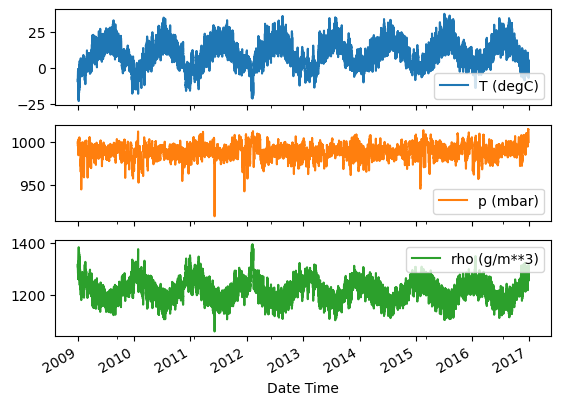

In [63]:
plot_features1.plot(subplots=True)

array([<Axes: xlabel='Date Time'>, <Axes: xlabel='Date Time'>,
       <Axes: xlabel='Date Time'>], dtype=object)

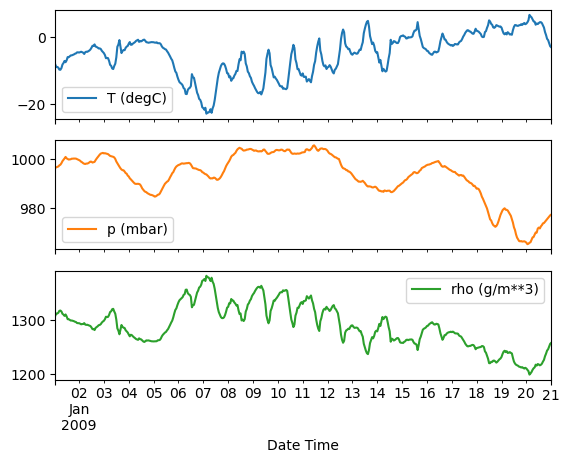

In [64]:
plot_features2.plot(subplots=True)

In [69]:
# outliers
df2.describe().transpose().loc["wv (m/s)":"max. wv (m/s)", "min"]

wv (m/s)        -9999.0
max. wv (m/s)   -9999.0
Name: min, dtype: float64

- 왜 부드럽게 처리해야 하는가?
> 바람의 방향을 부드럽게 처리해야 하는 이유는 데이터의 연속성과 모델의 정확성을 유지하기 위해서입니다. 바람의 방향은 원형 데이터로서 0°와 360°가 서로 이웃하고 연결되어 있습니다. 따라서 바람의 방향을 단순히 0과 360으로 구분하는 이진 변수로 다루는 것은 데이터의 연속성을 깨뜨리고 모델에 부정확한 정보를 제공할 수 있습니다.

예를 들어, 바람이 359°에서 1°만큼 시계방향으로 회전한 경우, 바람의 방향은 0°로 변화하게 됩니다. 그러나 0과 360을 서로 다른 값으로 취급하는 경우, 이 회전은 막대한 차이로 인식될 수 있습니다. 이는 실제로는 미세한 변화에 불과한 것일지라도 모델에 부정확한 영향을 미칠 수 있습니다.

따라서 바람의 방향을 부드럽게 처리함으로써 0°와 360°를 원형으로 연결하고, 미세한 변화를 부드럽게 처리하여 데이터의 연속성을 유지할 수 있습니다. 이는 모델이 바람의 방향을 정확하게 파악하고 패턴을 인식하는 데 도움을 줍니다. 또한, 부드러운 처리는 시각화나 다양한 분석 작업에서도 보다 일관성 있는 결과를 얻을 수 있게 합니다.

Text(0, 0.5, 'Wind Velocity[m/s]')

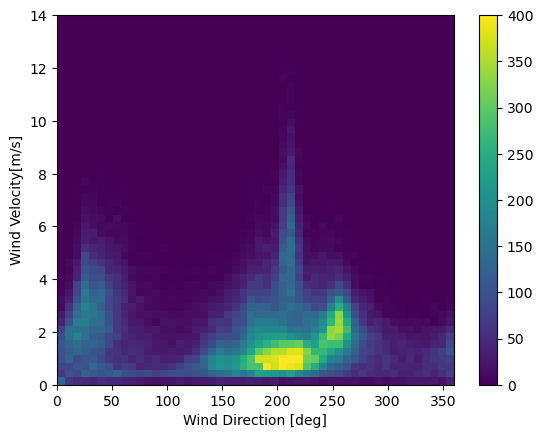

In [89]:
# 바람 데이터의 분포: 벡터로 변환이 필요하다
plt.hist2d(df4["wd (deg)"], df4["wv (m/s)"], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel("Wind Direction [deg]")
plt.ylabel("Wind Velocity[m/s]")

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

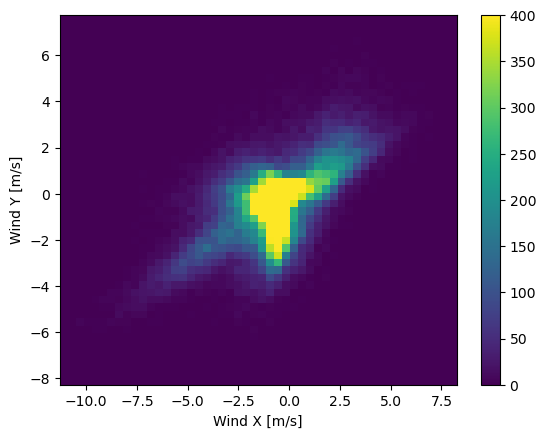

In [110]:
# 바람 벡터의 분포
plt.hist2d(df4["Wx"], df4["Wy"], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel("Wind X [m/s]")
plt.ylabel("Wind Y [m/s]")
ax = plt.gca()
ax.axis("tight")

해당 코드는 주어진 타임스탬프를 이용하여 시간 정보를 사인과 코사인 값으로 변환하는 작업을 수행합니다. 이를 통해 시간 정보를 주기성을 갖는 특성으로 변환하여 데이터에 추가합니다.

설명을 간단히 하자면:
- `day`는 하루에 해당하는 초 단위 시간입니다.
- `year`는 1년에 해당하는 초 단위 시간입니다.

다음으로, 주어진 타임스탬프를 활용하여 다음과 같은 특성을 생성합니다:
- `Day sin`: 타임스탬프를 하루의 주기로 나눈 값에 대한 사인 함수 값을 계산합니다. 이는 하루 내에서 시간의 주기성을 나타냅니다.
- `Day cos`: 타임스탬프를 하루의 주기로 나눈 값에 대한 코사인 함수 값을 계산합니다. 마찬가지로 하루 내에서 시간의 주기성을 나타냅니다.
- `Year sin`: 타임스탬프를 1년의 주기로 나눈 값에 대한 사인 함수 값을 계산합니다. 이는 1년 내에서 시간의 주기성을 나타냅니다.

이러한 변환을 통해 시간 정보를 주기성을 갖는 특성으로 바꾸어 모델이 계절성이나 주기성을 더 잘 파악하고 예측할 수 있도록 도움을 줍니다.

In [133]:
np.array(df4["Day sin"])[:25]

array([ 2.58819045e-01,  5.00000000e-01,  7.07106781e-01,  8.66025404e-01,
        9.65925826e-01,  1.00000000e+00,  9.65925826e-01,  8.66025404e-01,
        7.07106781e-01,  5.00000000e-01,  2.58819045e-01,  6.90329904e-12,
       -2.58819045e-01, -5.00000000e-01, -7.07106781e-01, -8.66025404e-01,
       -9.65925826e-01, -1.00000000e+00, -9.65925826e-01, -8.66025404e-01,
       -7.07106781e-01, -5.00000000e-01, -2.58819045e-01, -1.20299873e-11,
        2.58819045e-01])

Text(0.5, 1.0, 'Time of day signal')

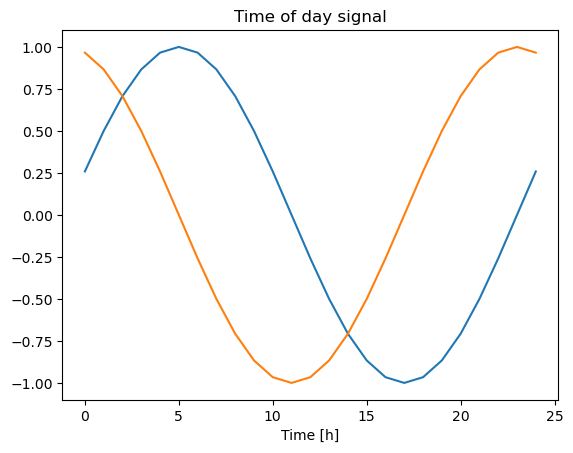

In [145]:
plt.plot(np.array(df4["Day sin"])[:25])
plt.plot(np.array(df4["Day cos"])[:25])
plt.xlabel("Time [h]")
plt.title("Time of day signal")

In [ ]:
#tf.signal.rfft of the temperature over time.

In [172]:
zip_path = tf.keras.utils.get_file(
    origin = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip",
    fname="jena_climate_2009_2016.csv.zip",
    extract=True)

csv_path, _ = os.path.splitext(zip_path)

df = pd.read_csv(csv_path)
df = df[5: :6]
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

wv = df["wv (m/s)"]
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0
max_wv = df["max. wv (m/s)"]
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0


wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')
wd_rad = df.pop('wd (deg)')*np.pi / 180
df["Wx"] = wv * np.cos(wd_rad)
df["Wy"] = wv * np.sin(wd_rad)
df["max Wx"] = max_wv * np.cos(wd_rad)
df["max Wy"] = max_wv * np.sin(wd_rad)

timestamp_s = date_time.map(pd.Timestamp.timestamp)
day = 24*60*60
year = (365.2425)*day
df["Day sin"] = np.sin(timestamp_s * (2 * np.pi /day))
df["Day cos"] = np.cos(timestamp_s * (2 * np.pi /day))
df["Year sin"] = np.sin(timestamp_s * (2 * np.pi / year))
df["Year cos"] = np.cos(timestamp_s * (2 * np.pi / year))

fft = tf.signal.rfft(df["T (degC)"])
f_per_dataset = np.arange(0, len(fft))
n_samples_h = len(df["T (degC)"])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h / (hours_per_year)
f_per_year = f_per_dataset / years_per_dataset

column_indices = {name: i for i, name in enumerate(df.columns)}
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]
num_features = df.shape[1]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                train_df=train_df, val_df=val_df, test_df=test_df,
                label_columns=None):
        #Store the raw data
        self.train_df = train_df
        self_val_df = val_df
        self.test_df = test_df
        
        # Work out the label column indices
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                         enumerate(label_columns)}
        self.column_indices = {name:i for i, name in
                              enumerate(train_df.columns)}
        
        # Work out the window parameters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column names(s): {self.label_columns}']) 

In [173]:
WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=["T (degC)"])

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column names(s): ['T (degC)']

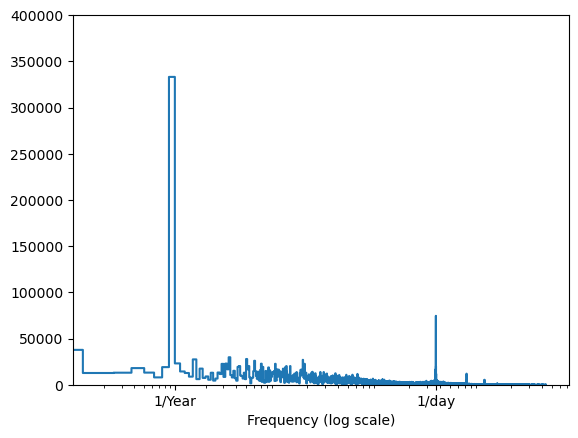

In [158]:
plt.step(f_per_year, np.abs(fft))
plt.xscale("log")
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=["1/Year", "1/day"])
_ = plt.xlabel("Frequency (log scale)")

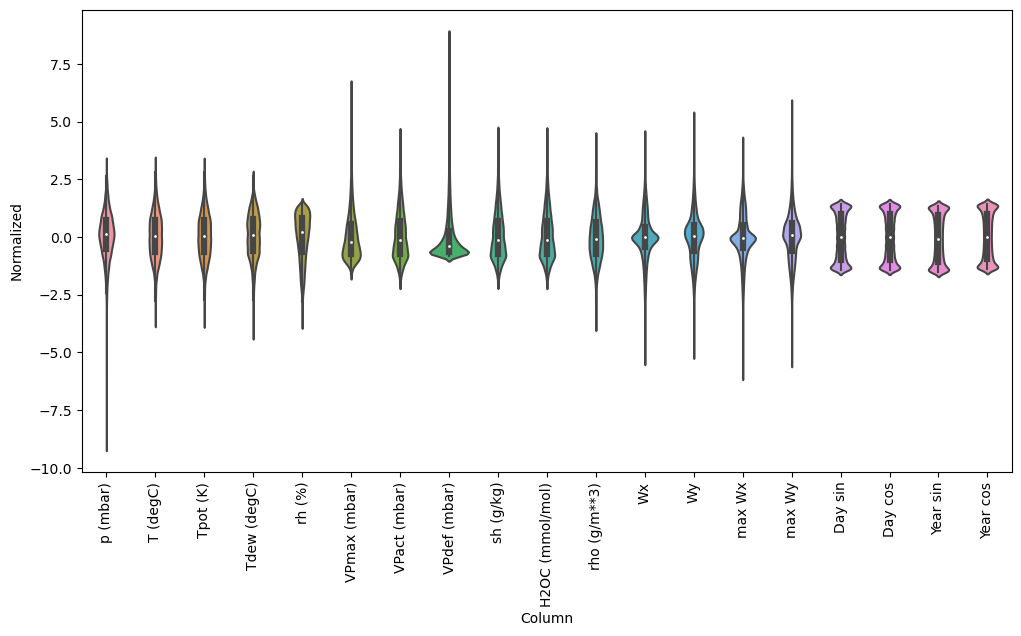

In [159]:
# 특성별 분포 살펴보기
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name="Column", value_name="Normalized")
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x="Column", y="Normalized", data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## WindowGenerator

이 코드는 `WindowGenerator`라는 클래스를 정의하는 코드입니다. 이 클래스는 시계열 데이터의 윈도우를 생성하는 기능을 제공합니다.

`WindowGenerator` 클래스의 생성자(`__init__` 메서드)는 다양한 매개변수를 입력받습니다. `input_width`는 입력 윈도우의 너비를 나타내며, `label_width`는 레이블 윈도우의 너비를 나타냅니다. `shift`는 윈도우를 이동시키는 값입니다. 또한 `train_df`, `val_df`, `test_df`는 각각 학습, 검증, 테스트 데이터를 나타내는 데이터프레임입니다. `label_columns`은 레이블로 사용할 열의 이름을 나타내는 리스트입니다.

이 클래스는 주어진 데이터를 저장하고, 레이블 열의 인덱스를 계산하고, 윈도우의 파라미터를 계산하는 등의 기능을 수행합니다. 또한 윈도우의 인덱스와 슬라이스를 계산하고, 클래스의 정보를 문자열로 반환하는 `__repr__` 메서드를 구현합니다.

`WindowGenerator` 클래스는 시계열 데이터를 윈도우로 변환하여 모델 훈련이나 예측에 활용할 수 있도록 도와주는 유용한 도구입니다.